# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

Repositorio Git: https://github.com/pfigueroa03/Proyecto03

In [1]:
# Importamos las librerias a utilizar. Muchas librerias no se importan al ya haberse trabajado en el notebook "Procesamiento"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import gc

import nltk

import spacy
nlp = spacy.load('es_core_news_sm')

In [2]:
# Generamos los 3 DF correspondientes.
data_dev = pd.read_json("dataset_es_dev.json", lines = True)
data_test = pd.read_json("dataset_es_test.json", lines = True)
data_train = pd.read_json("dataset_es_train.json", lines = True)

In [3]:
# Generamos un DF concatenando los 3 anteriores a los fines de trabajar sobre el total
data_amazon = pd.concat([data_dev, data_test, data_train])
data_amazon = data_amazon.reset_index(drop=True)

In [4]:
# Liberamos espacio en disco
del data_dev
del data_test
del data_train
gc.collect()

297

In [5]:
# Imprimimos el shape
data_amazon.shape

(210000, 8)

In [6]:
# Imprimimos el head para ver los 5 primeros registros
data_amazon.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [7]:
# Imprimimos el tail para ver los ultimos 5 registros
data_amazon.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
209995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electronics
209996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electronics
209997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,apparel
209998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,toy
209999,es_0859809,product_es_0378794,reviewer_es_0141717,5,"Súper bien! Las brochas son buenas, no sé meno...",Preciosas,es,home


In [8]:
# Verificamos que no presente valores NaN o nulos.
data_amazon.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

### Analisis exploratorio de datos

In [9]:
# Determinamos la distribucion de las reviews segun cantidad de estrellas.
data_amazon.groupby(["stars"])["stars"].count()

stars
1    42000
2    42000
3    42000
4    42000
5    42000
Name: stars, dtype: int64

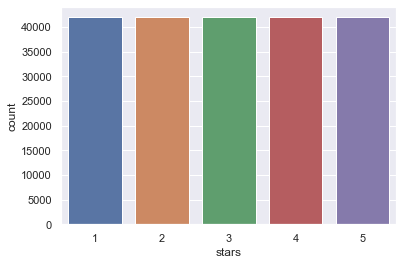

In [10]:
# Realizamos un countplot desagregado por la cantidad de estrellas para ver su distribucion de manera grafica.
sns.countplot(data = data_amazon, x = "stars")
plt.show()

Se evidencia que el DF esta compuesto por una distribucion equitativa para los 5 niveles de estrellas posibles.

#### Cual es la distribucion de los reviews por cantidad de reseñas de acuerdo al tipo de producto?

In [11]:
# Establecemos la cantidad de reviews por tipo de producto. Adicionalmente se evidencia la cantidad de categorias de productos presente en el DF
data_amazon.groupby(["product_category"])["stars"].count()

product_category
apparel                      6014
automotive                   7495
baby_product                 5098
beauty                       7707
book                         5528
camera                       3180
digital_ebook_purchase       1936
drugstore                    5778
electronics                 10899
furniture                    5481
grocery                      1107
home                        28328
home_improvement            11468
industrial_supplies          1552
jewelry                      1677
kitchen                      7028
lawn_and_garden              4449
luggage                      3509
musical_instruments          1608
office_product               5010
other                        4131
pc                          11720
personal_care_appliances     3735
pet_products                 3899
shoes                        2886
sports                      13856
toy                         14328
video_games                  1818
watch                        15

<AxesSubplot:title={'center':'Distribucion de cantidad de reviews por tipo de producto'}, xlabel='product_category', ylabel='count'>

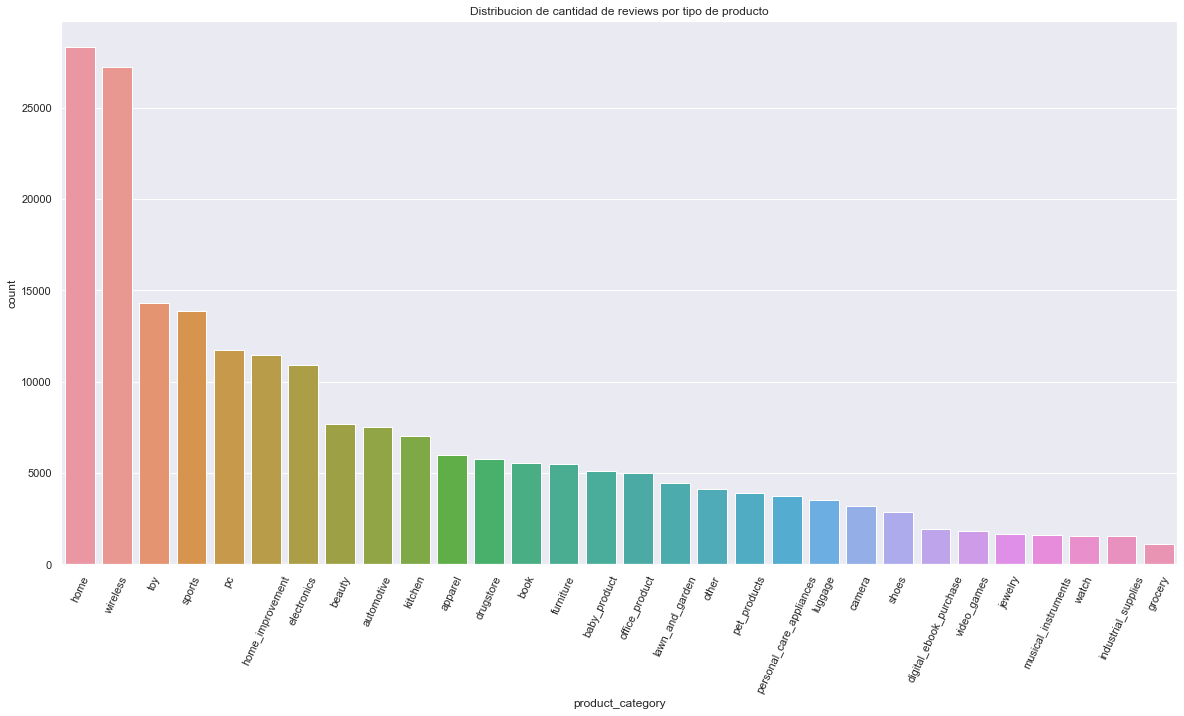

In [12]:
# Realizamos el grafico para ver mejor la distribucion, ordenandolo de mayor a menor cantidad de apariciones
plt.figure(figsize=(20, 10))
plt.title("Distribucion de cantidad de reviews por tipo de producto")
plt.xticks(rotation=65)
sns.countplot(data = data_amazon, x = data_amazon.product_category, order = data_amazon['product_category'].value_counts().index)

Se evidencia una presencia marcada de reviews en los rubros home y wireless, siendo adicionalmente las unicas categorias que presentan mas de 20.000 reviews. Procedemos a realizar un analisis mas detallado viendo la distribucion dentro de cada categoria segun la cantidad de estrellas dadas en cada reseña.

<AxesSubplot:title={'center':'Distribucion por cantidad de estrellas por tipo de producto'}, xlabel='product_category', ylabel='count'>

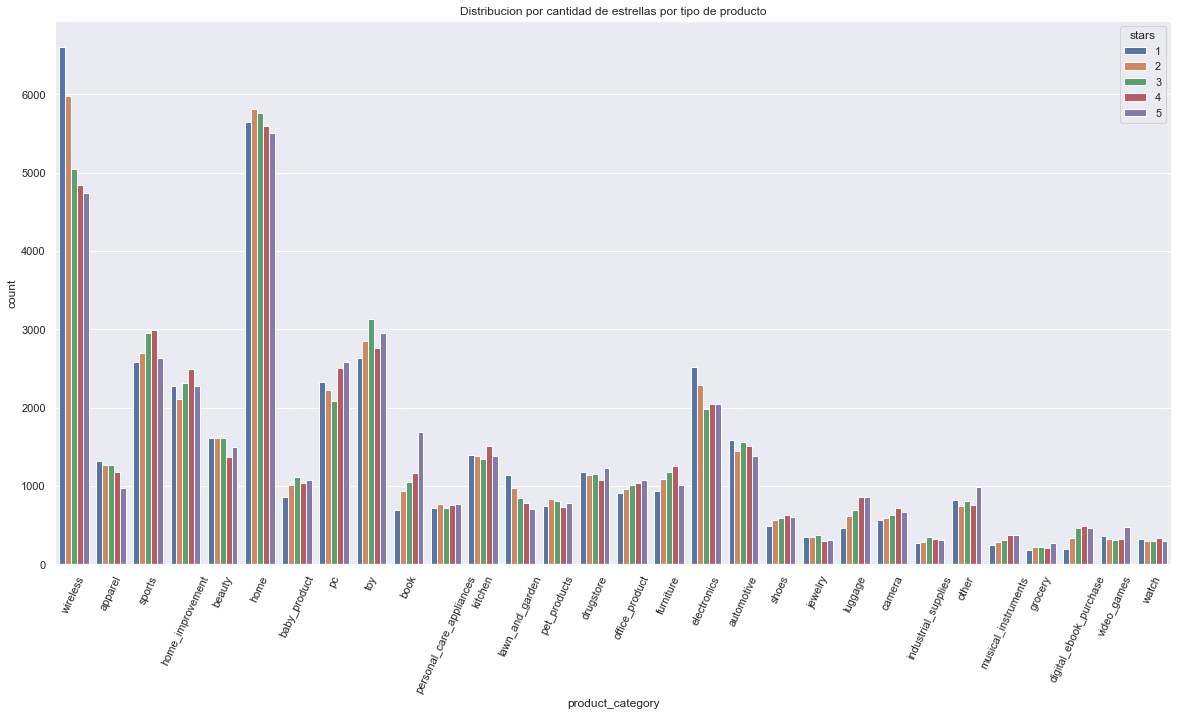

In [13]:
# Realizamos un grafico para ver la distribucion por tipo de producto de su correspondiente cantidad de estrellas
plt.figure(figsize=(20,10))
plt.title("Distribucion por cantidad de estrellas por tipo de producto")
plt.xticks(rotation=65)
sns.countplot(data = data_amazon, x = data_amazon.product_category, hue = 'stars')

Del grafico anterior se observa que en la mayoria de los casos, la distribucion interna no presenta mucha diferencia, siendo la distribucion pareja y por ende, el promedio de cada categoria deberia tender al valor 3, a los fines de verificarlo, se procede a realizar el analisis correspondiente.

In [14]:
# Determinamos el promedio de estrellas por tipo de producto y cargamos los valores en un DF
stars_avg = data_amazon.groupby(["product_category"])["stars"].mean()
stars_avg = pd.DataFrame(stars_avg.items(), columns = ['Categoria', 'Promedio_estrellas']) 

<AxesSubplot:title={'center':'Promedio de estrellas por categoria'}, xlabel='Categoria', ylabel='Promedio_estrellas'>

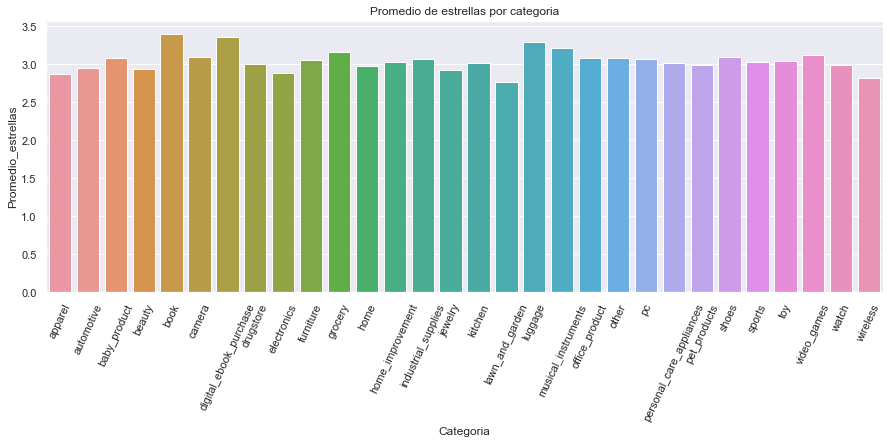

In [15]:
# Graficamos la distribucion de "stars_avg".
plt.figure(figsize=(15, 5))
plt.title("Promedio de estrellas por categoria")
plt.xticks(rotation=65)
sns.barplot(data = stars_avg, x = "Categoria", y = 'Promedio_estrellas')

Del grafico anterior se puede confirmar lo planteado anteriormente. El promedio de la distribucion de estrellas en cada categoria se encuentra proximo al valor 3, y presentandose una oscilacion entre 2.5 y 3.5 para todo el conjunto.

In [16]:
# Procedemos a limpiar memoria
del stars_avg
gc.collect()

2885

#### Cuantos usuarios han participado realmente en la emision de reseñas? Y cuantos productos han sido reseñados efectivamente?

In [17]:
# Establecemos la cantidad de usuarios unicos que contiene el DF
usuarios_unicos = pd.DataFrame(data_amazon['reviewer_id'].unique())
usuarios_unicos.count()

0    187140
dtype: int64

In [18]:
# Establecemos la cantidad de productos unicos que contiene el DF
productos_unicos = pd.DataFrame(data_amazon['product_id'].unique())
productos_unicos.count()

0    156458
dtype: int64

Verificando:
* El DF se compone de 210.000 registros y como se establecio anteriormente, no se presentan valores nulos o faltantes en el DF.

Usuarios:
* La cantidad de usuarios que participaron es de 187.140, lo que representa el 89,11% aproximadamente del total.

Productos:
* La cantidad de productos que han sido reseñados es de 156.458, valor que representa el 74,50% aproximadamente.

Atento a lo observado, surgen 2 interrogantes:

* 1- Cual es el usuario que mas reseñas emitio.
* 2- Cual es el producto que mas veces fue reseñado y a que categoria corresponde.

In [19]:
# Generamos un dataframe con la cantidad de participaciones por usuario
suma = pd.DataFrame(data_amazon.reviewer_id.value_counts())

In [20]:
# Lo ordenamos en forma descendente para verificar quienes poseen la mayor cantidad de participaciones
suma.sort_values(by = 'reviewer_id', ascending = False)

,reviewer_id
reviewer_es_0588051,7
reviewer_es_0437514,7
reviewer_es_0431022,7
reviewer_es_0475003,6
reviewer_es_0950209,6
...,...
reviewer_es_0552779,1
reviewer_es_0137766,1
reviewer_es_0086410,1
reviewer_es_0266707,1


Los usuarios que mas veces participaron, lo hicieron con un total de 7 veces cada uno.

In [21]:
# Imprimimos los registros correspondientes a los usuarios en cuestion.
data_amazon.loc[(data_amazon['reviewer_id'] == 'reviewer_es_0437514') | (data_amazon['reviewer_id'] == 'reviewer_es_0588051') | (data_amazon['reviewer_id'] == 'reviewer_es_0431022')]

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
19219,es_0555103,product_es_0633037,reviewer_es_0431022,1,"Mala elección, talla super pequeño, no lo devo...",no me gusto nada,es,apparel
25119,es_0043301,product_es_0918078,reviewer_es_0431022,1,"Lo tuve que devolver, se veía muy endeble y no...",endeble,es,electronics
45801,es_0761893,product_es_0825301,reviewer_es_0437514,1,No estoy muy contenta. No se ven todas las apl...,No lo vilveria a comprar,es,pc
56687,es_0134144,product_es_0166287,reviewer_es_0437514,2,Yo lo compre como despertador para el dormitor...,Es muy grande,es,electronics
61789,es_0673033,product_es_0149056,reviewer_es_0437514,2,Debe influir quién te da el masaje o la fe.,No me sirve de nada,es,drugstore
82673,es_0364344,product_es_0065839,reviewer_es_0431022,2,"Se rompió a la primera caída, creo q no son mu...",No lo recomiendo,es,wireless
92233,es_0673224,product_es_0616815,reviewer_es_0588051,3,"Generó super fino, se notan mucho las costuras...",No me la quede.,es,sports
92549,es_0564588,product_es_0315730,reviewer_es_0437514,3,"Las he comprado por su precio, algo mas barata...",No merece la pena,es,home
94353,es_0188523,product_es_0145354,reviewer_es_0588051,3,"Me gusto mucho el tacto , pero el género hacía...",Calidad mediocre.,es,sports
97843,es_0254703,product_es_0420214,reviewer_es_0588051,3,"La idea y el producto yo se ve de calidad , pe...",Buena cosa,es,sports


Imprimimos en pantalla los registros para los usuarios con mas reseñas. No se observa una tendencia atento a que la categoria de producto varia y la cantidad de estrellas tambien.
En este caso en particular, invita a un analisis mas profundo para determinar con mas claridad las distribuciones presentes.

In [22]:
# Generamos un DF con la cantidad de veces que fue reseñado cada producto
producto_total = pd.DataFrame(data_amazon.product_id.value_counts())

In [23]:
# Lo ordenamos de mayor a menos para determinar cual es el que aparece mas veces
producto_total.sort_values(by = 'product_id', ascending = False)

,product_id
product_es_0261843,8
product_es_0544842,7
product_es_0808483,7
product_es_0523350,7
product_es_0616440,7
...,...
product_es_0307214,1
product_es_0508976,1
product_es_0053862,1
product_es_0463072,1


In [24]:
# Imprimimos los registros para el producto en cuestion.
data_amazon.loc[(data_amazon['product_id'] == 'product_es_0261843')]

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
21612,es_0233364,product_es_0261843,reviewer_es_0855637,1,No son las canicas de la foto. Son pequeñas y ...,Decepcion,es,toy
37746,es_0015129,product_es_0261843,reviewer_es_0782745,1,"El producto aún no ha llegado, tenía que llega...",Estafa,es,toy
48929,es_0900151,product_es_0261843,reviewer_es_0634470,1,"Una pena, las canicas son muy cutres, lo único...",Canicas todo a 100,es,toy
77287,es_0953681,product_es_0261843,reviewer_es_0978294,2,Son caras y vienen muchas repetidas y ROTAS. L...,Rotas representante y caras. Vete al chino que...,es,toy
105799,es_0529308,product_es_0261843,reviewer_es_0981219,3,"Han venido unas pocas rotas, como son tantas n...",Algunas rotas,es,toy
134428,es_0101224,product_es_0261843,reviewer_es_0948003,4,Ha sido un regalo para un niño de 6 años y le ...,Bueno,es,toy
146414,es_0582312,product_es_0261843,reviewer_es_0000856,4,Buen producto...pero se ve que se había caído ...,Un juguete retro muy logrado.,es,toy
166144,es_0361862,product_es_0261843,reviewer_es_0978422,4,Excelente producto. Ideal para regalo a los má...,Excelente presentación,es,toy


Imprimimos en pantalla los registros del producto mas reseñado y vemos que se corresponde a la categoria "toy" con un promedio de estrellas de 2.5

In [25]:
del usuarios_unicos
del productos_unicos
del data_amazon
del suma
del producto_total
gc.collect()

110

### Analisis exploratorio con NLP

In [26]:
# Traemos las stopwords de la libreria spacy en español.
from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

# Del conjunto de stopwords, dejamos "no", "pero", "porque", "sin", "ni", "nada". Atento a que pueden tener mayor presencia en algun registro puntual de estrellas.
stopwords_spacy.remove('no')
stopwords_spacy.remove('pero')
stopwords_spacy.remove('porque')
stopwords_spacy.remove('sin')
stopwords_spacy.remove('ni')
stopwords_spacy.remove('nada')

In [27]:
# Importamos el DF trabajado en el notebook de "procesamiento"
df_amazon = pd.read_csv('amazon.csv')

In [28]:
# Verificamos las columnas que conforman el DF
df_amazon.columns

Index(['Unnamed: 0', 'stars', 'review_body', 'review_title',
       'product_category', 'Stemm', 'Lemm'],
      dtype='object')

In [29]:
# Eliminamos la primera columna por ser irrelevante
df_amazon = df_amazon.drop('Unnamed: 0', axis = 1)

In [30]:
# Cargamos 5 DF nuevos separados por cantidad de estrellas a los fines de hacer un analisis mas detallado.
df_amazon_one = df_amazon.loc[(df_amazon['stars'] == 1)]
df_amazon_two = df_amazon.loc[(df_amazon['stars'] == 2)]
df_amazon_thr = df_amazon.loc[(df_amazon['stars'] == 3)]
df_amazon_fou = df_amazon.loc[(df_amazon['stars'] == 4)]
df_amazon_fiv = df_amazon.loc[(df_amazon['stars'] == 5)]

In [31]:
# Imprimimos los shape de todos los DF para ver la distribucion.
print(df_amazon_one.shape)
print(df_amazon_two.shape)
print(df_amazon_thr.shape)
print(df_amazon_fou.shape)
print(df_amazon_fiv.shape)

(42000, 6)
(42000, 6)
(42000, 6)
(42000, 6)
(42000, 6)


In [32]:
# Generamos el head correspondiente a uno de los DF a los fines de verificar que se haya cargado correctamente
df_amazon_one.head()

,stars,review_body,review_title,product_category,Stemm,Lemm
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless,malisim grand demasi aparat mal protector pant...,malisimo grande demasiado aparatoso mal protec...
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel,no recib ped no devoluci n no recib,no recibido pedido no devoluci n no recibido
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports,busc sistem no funcion bien abrazader llev aga...,buscar sistema no funciona bien abrazadera lle...
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement,utilic broc menor di metr dobl vari si mantequ...,utilic brocas menor di metro doblaron varias s...
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty,no gust olor viej aspect mal no gust,no gusta olor viejo aspecto malo no gusta


Se procedera a realizar el analisis trabajando unicamente con "Adjetivos", atento a que se pueden relacionar de mejor manera con sentimientos, y por ende, servir mejor para predecir si una reseña es positiva o negativa. Se trabajara con la libreria de spaCy dado que es mas practica para trabajar con la funcion de las palabras en una oracion.

In [33]:
# Definimos una funcion para filtrar los adjetivos de las reseñas "Lemm".
def adj_lemm(dataframe):
    adjetivos = []
    for i in dataframe.index:
        lemm_adj = dataframe.Lemm[i] 
        lemm_adj = nlp(lemm_adj.lower())
        for token in lemm_adj:
            if (token.pos_ == "ADJ" and token.text not in stopwords_spacy and token.text and len(token.text)>2):
                lemm_clear = token.lemma_
                adjetivos.append(lemm_clear)
    return adjetivos

In [34]:
# Definimos una funcion para filtrar los adjetivos de las reseñas "stemm"
def adj_stemm(dataframe):
    adjetivos = []
    for i in dataframe.index:
        stemm_adj = dataframe.Stemm[i]
        stemm_adj = nlp(stemm_adj.lower())
        for token in stemm_adj:
            if (token.pos_ == "ADJ" and token.text not in stopwords_spacy and token.text and len(token.text)>2):
                stemm_clear = token.lemma_
                adjetivos.append(stemm_clear) #
    return adjetivos

In [35]:
# Generamos las listas de palabras que sean adjetivos para las frases lemmatizadas, desagregadas por cantidad de estrellas.
lemm1_adj = adj_lemm(df_amazon_one)
lemm2_adj = adj_lemm(df_amazon_two)
lemm3_adj = adj_lemm(df_amazon_thr)
lemm4_adj = adj_lemm(df_amazon_fou)
lemm5_adj = adj_lemm(df_amazon_fiv)

In [36]:
# Generamos las listas de palabras que sean adjetivos para las frases stemmizadas, desagregadas por cantidad de estrellas
stemm1_adj = adj_stemm(df_amazon_one)
stemm2_adj = adj_stemm(df_amazon_two)
stemm3_adj = adj_stemm(df_amazon_thr)
stemm4_adj = adj_stemm(df_amazon_fou)
stemm5_adj = adj_stemm(df_amazon_fiv)

In [37]:
# Definimos una funcion que al pasarle una lista, nos devuelve la frecuencia que aparece cada palabra en formato de DF.
def pasa_palabra(dataframe, estrellas):
    data_palabra = nltk.FreqDist(dataframe)
    data_palabra = pd.DataFrame(data_palabra.items(), columns = ['Palabra', 'Frecuencia'])
    data_palabra['stars'] = estrellas
    data_palabra = data_palabra.sort_values(by = ['Frecuencia'], ascending = False)
    return data_palabra

In [38]:
# Definimos una funcion que genera un grafico con un dataframe para ver la distribucion de las palabras segun su frecuencia de aparicion.
def graficar(dataframe):
    plt.figure(figsize = (15,5))
    plot = sns.barplot(x  = dataframe.iloc[:30].Palabra, y = dataframe.iloc[:30].Frecuencia)
    for item in plot.get_xticklabels():
        item.set_rotation(90)
    plt.show()

In [39]:
# Generamos los DF con frecuencia para los adjetivos lemmatizados
lemm1_adj = pasa_palabra(lemm1_adj, 1)
lemm2_adj = pasa_palabra(lemm2_adj, 2)
lemm3_adj = pasa_palabra(lemm3_adj, 3)
lemm4_adj = pasa_palabra(lemm4_adj, 4)
lemm5_adj = pasa_palabra(lemm5_adj, 5)

In [40]:
# Generamos los DF con frecuencia para los adjetivos stemmizados
stemm1_adj = pasa_palabra(stemm1_adj, 1)
stemm2_adj = pasa_palabra(stemm2_adj, 2)
stemm3_adj = pasa_palabra(stemm3_adj, 3)
stemm4_adj = pasa_palabra(stemm4_adj, 4)
stemm5_adj = pasa_palabra(stemm5_adj, 5)

Teniendo generados los DF con las frecuencias de palabras correspondientes. Procedemos a generar los graficos con dicha distribucion para determinar presencia y participacion en distintos niveles de reseña.

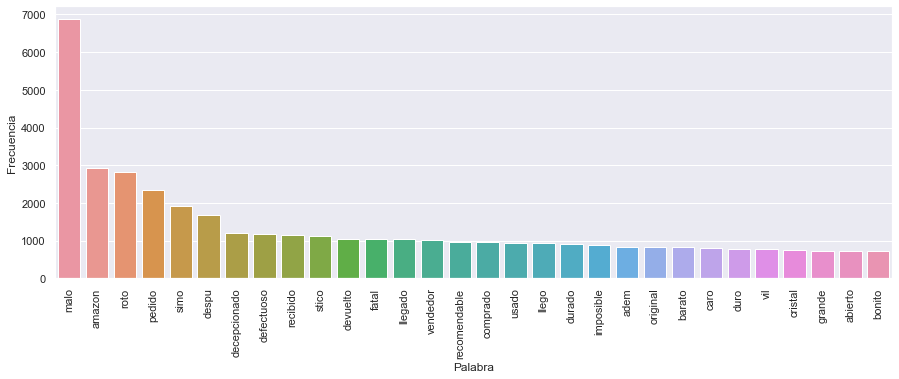

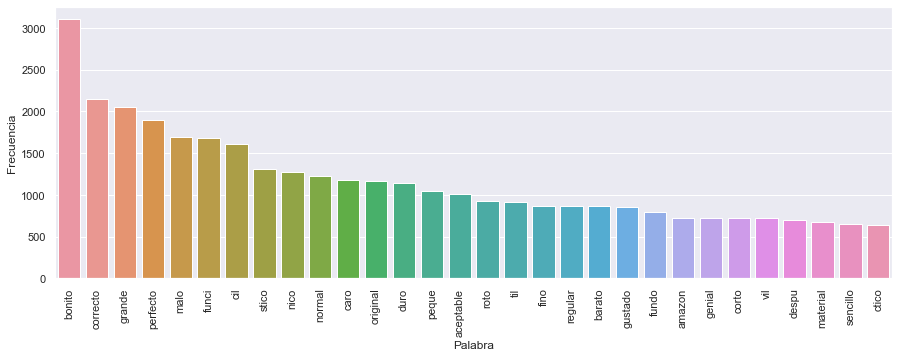

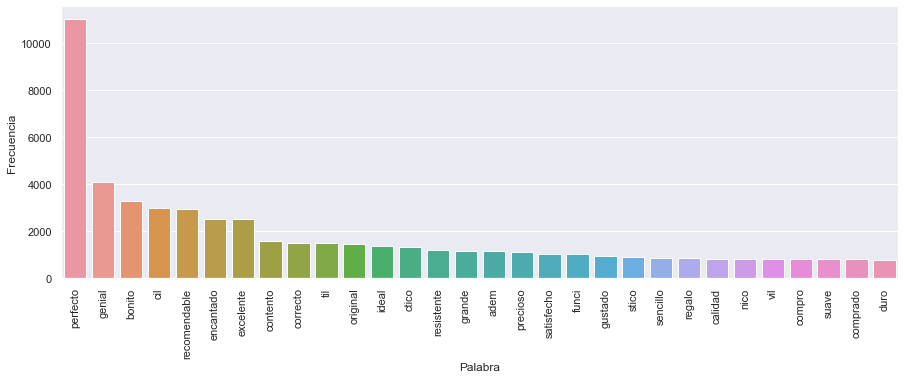

In [41]:
# Graficamos las frecuencias para 1, 3 y 5 estrellas de adjetivos lemmatizados
graficar(lemm1_adj)
graficar(lemm3_adj)
graficar(lemm5_adj)

De los graficos anteriores podemos determinar:
* Para 1 estrella, las palabras que mas lo representan son: "malo" y "roto".
* Para 3 estrellas, las palabras que mas lo representan son: "bonito" y "correcto"
* Para 5 estrellas, las palabras que mas lo representan son: "Perfecto" y "genial"

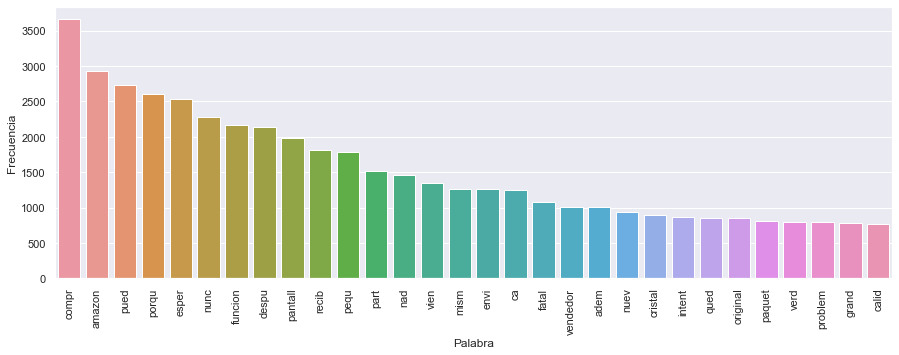

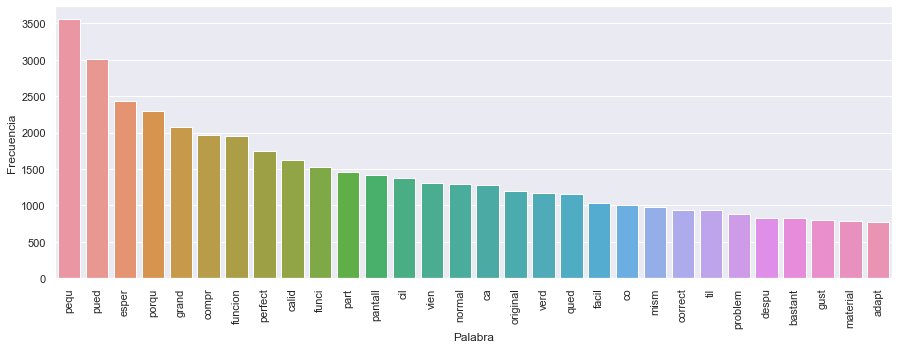

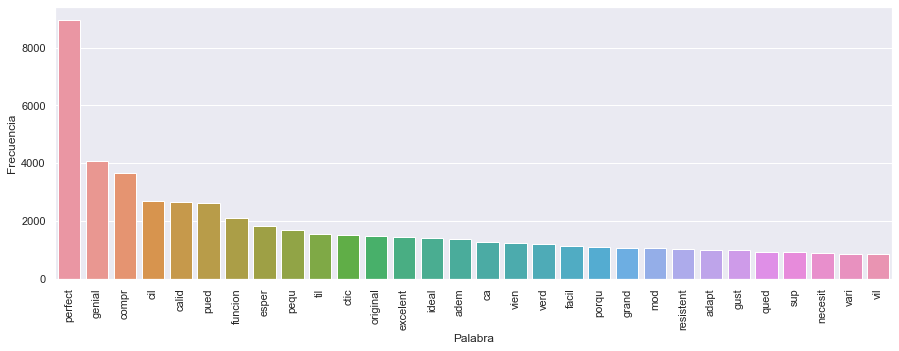

In [42]:
# Graficamos las frecuencias para 1, 3 y 5 estrellas de adjetivos stemmizados
graficar (stemm1_adj)
graficar(stemm3_adj)
graficar(stemm5_adj)

De los graficos anteriores, llama la atencion a simple viste que no se distingue una palabra que funcione de referencia como en el caso de las frases lemmantizadas. En esta oportunidad, dicha situacion se presenta unicamente al considerar la frecuencia en reviews de 5 estrellas, siendo la palabra que mas sobresale "perfect".

In [43]:
# Procedemos a liberar memoria
del lemm1_adj
del lemm2_adj
del lemm3_adj
del lemm4_adj
del lemm5_adj
del stemm1_adj
del stemm2_adj
del stemm3_adj
del stemm4_adj
del stemm5_adj
del df_amazon_one
del df_amazon_two
del df_amazon_thr
del df_amazon_fou
del df_amazon_fiv
gc.collect()

16954

### Comenzamos a trabajar con la modelizacion

* Se generaran modelos de prediccion desagregando las frases Lemmatizadas y Stemmizadas.
* Para ambos grupos de palabras, se desarrollaran 3 modelos y se compararan entre si, tomando el mismo train split, a los fines de determinar el que posea mejor desempeño.
* De los 6 modelos generados, se tomara aquel que posea mejor desempeño, para optimizarlo por medio de GridSearchCV, a los fines de determinar cambios en los resultados al trabajar con hiperparametros optimizados por algoritmo.
* El criterio de seleccion a aplicar sera el de "accuracy_score", siendo el mejor resultado aquel que presente el mayor valor.

### Vectorizar

In [44]:
# Generamos listas con las frases "lemmatizadas", "stemmizadas" y asignamos la columna "stars" a una variable.
lemm_frases = list(df_amazon["Lemm"])
stemm_frases = list(df_amazon['Stemm'])
stars_frases = df_amazon['stars']

In [45]:
# Importamos la libreria a utilizar
from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 2500 palabras con mas frecuencia
max_features=2500
cou_vec=CountVectorizer(max_features=max_features, ngram_range=(1, 2))

In [46]:
# Ajustamos el modelo a trabajar con las frases lemmatizadas
matriz_titulos = cou_vec.fit_transform(lemm_frases)

In [47]:
# Generamos las variables para el modelo
x = matriz_titulos.toarray()
y = stars_frases

In [48]:
# Definimos una funcion que grafique la matriz de confusion.
def confusion(ytest,y_pred):
    names=["1 Estrella", "2 Estrellas", "3 Estrellas", "4 Estrellas", "5 Estrellas"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### Modelos Lemm

In [49]:
# Importamos el train test split y realizamos la separacion correspondiente. Se utiliza una distribucion del 70% para entrenamiento, y 30% para prueba
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [50]:
# Importamos las librerias a implementar en esta instancia.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#### Naive Bayes

In [51]:
# Generamos el modelo correspondiente, lo entrenamos y generamos la prediccion. Se imprime en pantalla el resultado obtenido en el criterio de seleccion.
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
y_pred_nb_l = nb.predict(xtest)

print("acc : ", accuracy_score(ytest, y_pred_nb_l))

acc :  0.4503333333333333


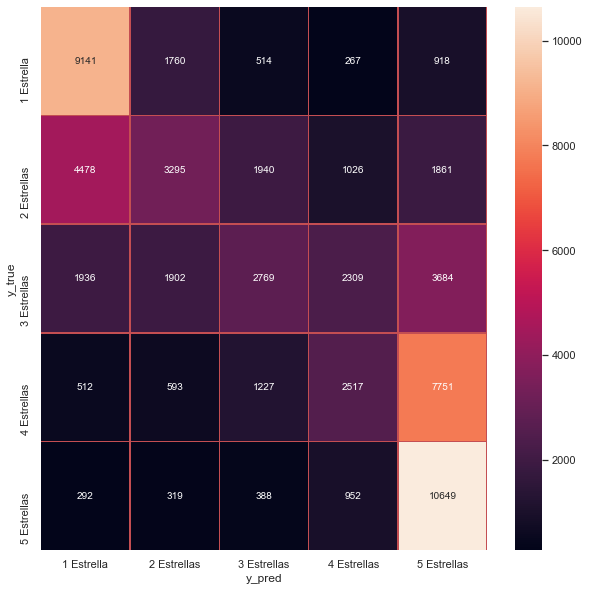

In [52]:
# Utilizamos la funcion para graficar la matriz de confusion correspondiente.
confusion(ytest,y_pred_nb_l)

Se observa que el modelo funciona bien en los extremos, es decir, en los casos en los que correspondian 5 estrellas y 1 estrella. 

Adicionalmente se observan algunas inconsistencias:
* En el caso en el cual el valor verdadero era de 1 estrella, el modelo asigno 5 estrellas en 867 oportunidades, mientras que asigno 3 y 4 estrellas en 781 situaciones.
* Para el caso de 3 estrellas reales, es donde se observa la mayor variacion respecto a la distribucion de las predicciones, encontrandose una tendencia a asignar 3 o mas estrellas.
* En aquella situacion en la cual el valor verdadero era de 5 estrellas, es donde el modelo predijo mejor, con una precision del 81,75%

#### Random Forest

In [53]:
# Se genera el modelo correspondiente, se ajusta y se carga la prediccion. Se imprime el resultado del accuracy score en pantalla.
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42, n_estimators = 35)
rf.fit(xtrain, ytrain)
y_pred_forest_l = rf.predict(xtest)

print("acc : ", accuracy_score(ytest, y_pred_forest_l))

acc :  0.49207936507936506


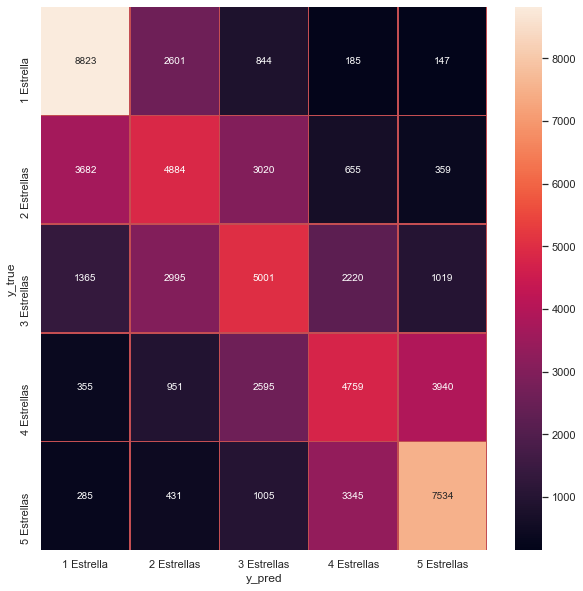

In [54]:
# Se genera la matriz de confusion correspondiente.
confusion(ytest,y_pred_forest_l)

A diferencia del modelo Naive Bayes, se observa un resultado mas consistente en las predicciones al considerar los valores predichos con los reales.

Consideraciones:
* Para todos los casos, se observa que el mayor valor se encuentra en la diagonal principal de la matriz, lo cual indica que el modelo predijo bien en la mayoria de las situaciones.
* No se observa la inconsistencia observada en el modelo de Naive Bayes respecto a aquella situacion en la cual, cuando el valor real era 1 estrella, el modelo habia predicho mas veces 5 estrellas que 3 o 4.
* En contra, este modelo presenta mayor variacion en los extremos. Si tomamos nuevamente el caso de 5 estrellas en su valor real, el modelo solo predice bien en el 62,61% de las veces, contra el 81,75% del modelo Bayesiano.

#### SVM

In [55]:
# Cargamos el modelo correspondiente, lo entrenamos y establecemos la prediccion. Imprimimos en pantalla el resultado obtenido.
from sklearn.svm import LinearSVC

svc_l = LinearSVC(C = 1)
svc_l.fit(xtrain, ytrain)
y_pred_svc_l = svc_l.predict(xtest)

print("acc : ", accuracy_score(ytest, y_pred_svc_l))

C:\Users\Pablo\miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc :  0.5395238095238095


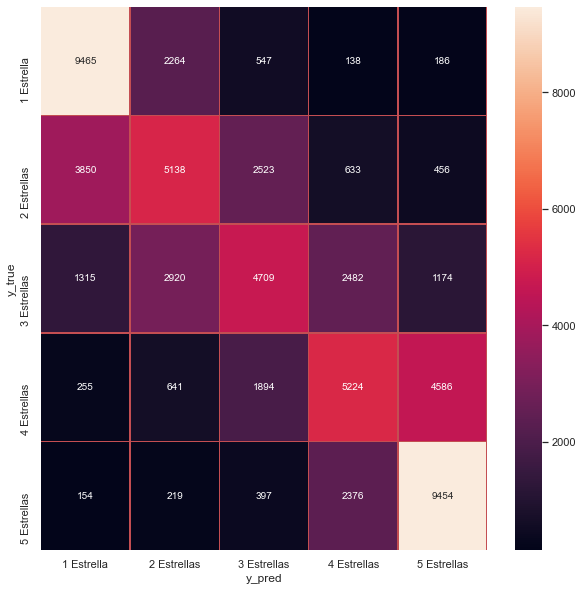

In [56]:
# Realizamos la matriz correspondiente.
confusion(ytest,y_pred_svc_l)

Hasta el momento, es el modelo con mejor resultado, situacion que se evidencia en su accuracy_score y en un primer vistazo a la matriz de confusion generada.

Consideraciones:
* El modelo es bastante consistente, al igual que en el anterior, la diagonal principal presenta los mayores valores observados.
* El modelo funciona bien para los extremos. Si tomamos nuevamente el valor de 5 estrellas, predice correctamente en el 74% aproximadamente.

### Modelos Stemm

Se procede a realizar los mismos pasos para las frases stemmizadas, a los fines de poder comparar los resultados y determinar cual funciona mejor.

In [57]:
# Ajustamos el modelo a trabajar con las frases stemmatizadas
matriz_titulos_stemm = cou_vec.fit_transform(stemm_frases)

In [58]:
# Generamos las variables x e y y realizamos el split correspondiente. Los valores se mantienen igual que el modelo Lemm
x = matriz_titulos_stemm.toarray()
y = stars_frases

xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

#### Naives Bayes

In [59]:
# Generamos el modelo, lo entrenamos y predecimos. Imprimos en pantalla el valor obtenido.
#from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
y_pred_nb_s = nb.predict(xtest)

print("acc : ", accuracy_score(ytest, y_pred_nb_s))

acc :  0.44771428571428573


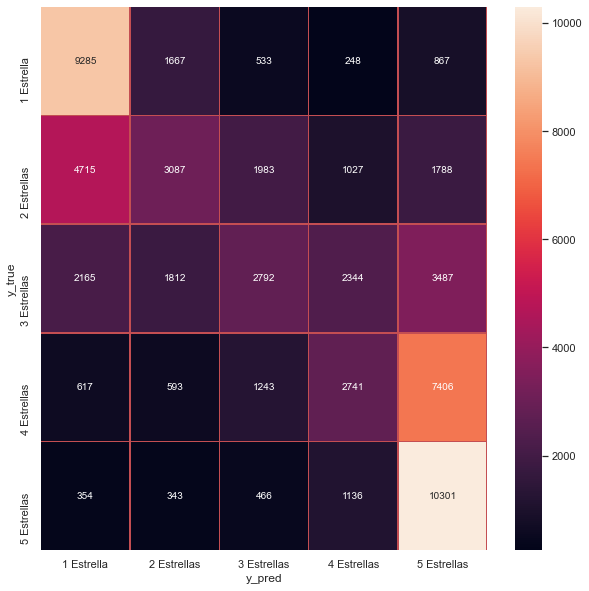

In [60]:
# Generamos la matriz correspondiente.
confusion(ytest,y_pred_nb_s)

Se observa que el modelo funciona bien en los extremos, es decir, en los casos en los que correspondian 5 estrellas y 1 estrella. La diagonal principal se corresponde con la mayor cantidad de observaciones, pero presenta una mayor distribucion alrededor de la misma, pudiendo explicarse en este aspecto el bajo valor del accuracy obtenido.

#### Random Forest

In [61]:
# Generamos el modelo, lo entrenamos y predecimos. Imprimimos el resultado obtenido.
rf = RandomForestClassifier(random_state = 42, n_estimators = 35)
rf.fit(xtrain, ytrain)
y_pred_forest_s = rf.predict(xtest)

print("acc : ", accuracy_score(ytest, y_pred_forest_s))

acc :  0.5031111111111111


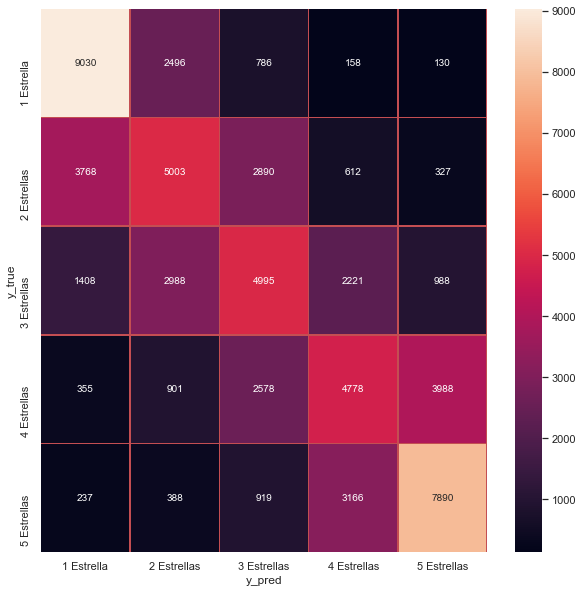

In [62]:
# Generamos la matriz correspondiente.
confusion(ytest,y_pred_forest_s)

De acuerdo al accuracy obtenido, se observa una mejoria en el resultado respecto al modelo de Bayes. Tambien se observa en este modelo que la diagonal principal presenta las mayores observaciones.


#### SVM

In [63]:
# from sklearn.svm import LinearSVC
# Generamos el modelo, lo entrenamos y predecimos. Imprimimos en pantalla el score obtenido.
svc = LinearSVC(C = 1)
svc.fit(xtrain, ytrain)
y_pred_svc_s = svc.predict(xtest)

print("acc : ", accuracy_score(ytest, y_pred_svc_s))

C:\Users\Pablo\miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc :  0.5388888888888889


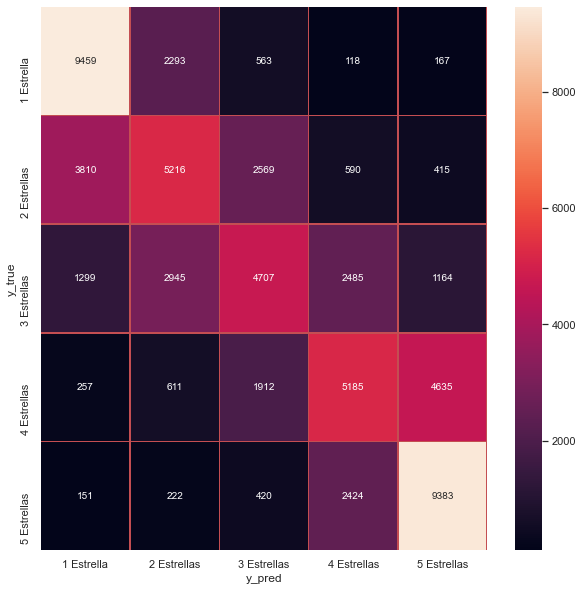

In [64]:
# Generamos la matriz de confusion.
confusion(ytest,y_pred_svc_s)

El modelo presenta, al igual que para el caso de las frases lemmatizadas, el mayor score de los 3 modelos desarrollados, pero para el caso de las frases "lemm" el resultado es ligeramente mejor..

Consideraciones:
* La diagonal principal presenta las mayores observaciones.
* El modelo funciona mejor en los valores extremos, es decir, para 1 y 5 estrellas.

In [65]:
# Liberamos memoria
del svc
del rf
del nb
del svc_l
gc.collect()

33791

#### Optimizando con GridSearch

Acorde a los modelos entrenados anteriormente, y comparando los resultados entre aquellos entrenados con frases lemm y aquellos con frases stemm, se procedera a realizar una optimizacion de hiperparametros por medio de GrisSearchCV.
El modelo a considerar sera unicamente aquel que obtuvo mayor accuracy_score de los 6 modelos anteriores, es decir, linearSVC para frases lemm.

In [66]:
# Importamos la libreria de GridSearchCV para utilizarla con el fin de optimizar los hiperparametros.
from sklearn.model_selection import GridSearchCV

In [67]:
# Definimos el param_grid para utilizar en el Grid Search
param_grid = {'max_iter': [1250, 1500],
              'C': [0.4, 0.5, ]}     

In [68]:
# Ajustamos el modelo a trabajar con las frases lemmatizadas
matriz_titulos = cou_vec.fit_transform(lemm_frases)
x = matriz_titulos.toarray()
y = stars_frases

In [69]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [70]:
# Generamos el modelo a optimizar por gridsearch
svc_l = LinearSVC()
#svc_l.fit(xtrain, ytrain)

In [71]:
grid_model = GridSearchCV(svc_l, param_grid=param_grid, cv=2, n_jobs = 3)

In [72]:
grid_model.fit(xtrain, ytrain)

C:\Users\Pablo\miniconda3\envs\datascience\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=2, estimator=LinearSVC(), n_jobs=3,
             param_grid={'C': [0.4, 0.5], 'max_iter': [1250, 1500]})

In [73]:
y_predict = grid_model.predict(xtest)

In [74]:
print("Mejores parametros: "+str(grid_model.best_params_))

Mejores parametros: {'C': 0.4, 'max_iter': 1500}


In [75]:
print("acc : ", accuracy_score(ytest, y_predict))

acc :  0.5396507936507936


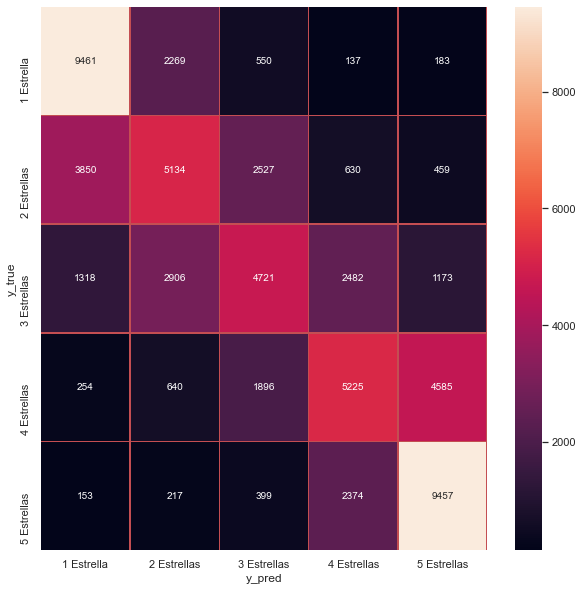

In [76]:
# Generamos la matriz de confusion.
confusion(ytest,y_predict)

Al optimizar parametros por medio del GreadSearchCV, solo se evidencian variaciones menores en las predicciones realizadas, situacion que queda en manifiesto al observarse diferencias en el "accuracy_score" a partir del valor 0.00001.

### Investigacion

Despues del proceso y analisis realizado, considero que seria interesante:
* Realizar un trabajo similar sobre un DataFrame que no presente una distribucion equitativa, pero que no se encuentre sesgada, respecto a la distribucion de las reviews. En el trabajo actual, la distribucion era del 0.20 para cada estrella.
* Trabajar sobre todo el conjunto de frases, lemmantizadas y stemmizadas, para analizar variacion y si es positivo o negativo para alguno de los modelos el hecho de poseer mas palabras para cada nivel de review.
* Considerar los mismos reviews, pero trabajados en idioma Ingles.
* Considerar grupos de palabras de acuerdo a su funcion en la oracion para entrenar distintos modelos y poder compararlos entre si y con los entrenados en este proyecto para determinar si se encuentra una mejoria en el desempeño.

#### Acercamiento una matriz con todas las frases generadas.

A los fines de indagar en uno de los puntos mencionados anteriormente. Se procedera a realizar un modelo de Naive Bayes con todas las frases, tambien trabajandolo con el criterio del accuracy_score, se procedera a comparar el resultado obtenido con el mismo modelo para las frases por separado. 

In [77]:
# Generamos las listas con las estrellas otorgadas.
stars_frases = list(df_amazon['stars'])
stars_frases_1 = list(df_amazon['stars'])

In [78]:
# Generamos una unica lista que repita la cantidad de estrellas a los fines de que coincida con la lista de todas las frases.
estrellas_total = stars_frases + stars_frases_1

In [79]:
# Generamos una unica lista que contenga las frases lemmantizadas y stemmizadas
frases = lemm_frases + stemm_frases

In [80]:
# Generamos el vector correspondiente.
max_features = 2500
cou_vec=CountVectorizer(max_features=max_features, ngram_range=(1, 2))

In [81]:
# Generamos la matriz
matriz_frases = cou_vec.fit_transform(frases)

In [82]:
# Establecemos las variables x e y
x = matriz_frases.toarray()
y = estrellas_total

In [83]:
# Realizamos el train_test_split correspondiente
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [84]:
# Generamos, entrenamos y realizamos la prediccion del modelo en cuestion.
nb_t = GaussianNB()
nb_t.fit(xtrain,ytrain)
y_pred_nb_t = nb_t.predict(xtest)

print("acc : ", accuracy_score(ytest, y_pred_nb_t))

acc :  0.4454444444444444


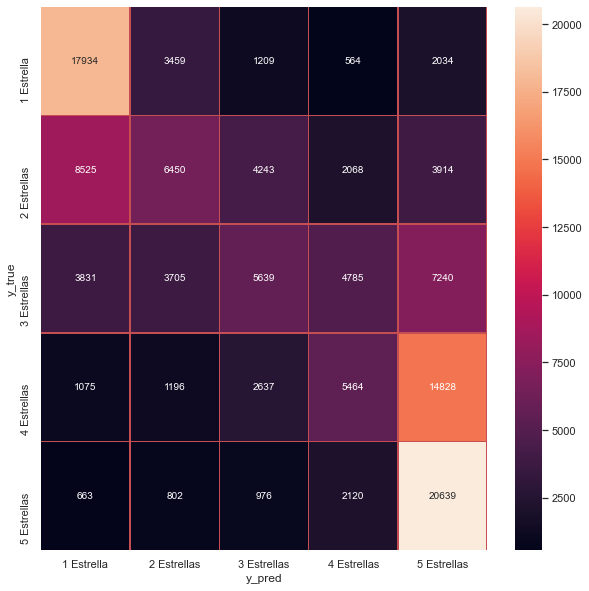

In [85]:
# Generamos la matriz de confusion.
confusion(ytest,y_pred_nb_t)

De los resultados obtenidos, al compararlos encontramos:

* Accuracy para el modelo con frases lemm y stemm: 0.4462777777777778
* Accuracy para el modelo con frases lemm: 0.4503333333333333
* Accuracy para el modelo con frases stemm: 0.44771428571428573

el accuracy obtenido disminuyo respecto a los dos modelos entrenados con frases por separado

In [86]:
del stars_frases
del stars_frases_1
del estrellas_total
del frases
del matriz_frases
gc.collect()

11296